In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens
import cv2

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr, spearmanr 
import scipy.stats as stats

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

#network
import networkx as nx

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import chi2_distance, ts_visual, time_series_henColumn_tsRow, correct_key, FB_daily
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_dataoutput = config.path_dataoutput
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)
dico_night_hour = config.dico_night_hour
dico_matching = config.dico_matching
li_binmn = config.li_binmn
penalty = config.penalty
dico_HAID_date = config.dico_HAID_date
dico_window = config.dico_window
path_extracted_HA = config.path_extracted_HA
path_extracted_HA_visual = config.path_extracted_HA_visual
path_extracted_data_SNA = config.path_extracted_data_SNA
#create a director if not existing
if not os.path.exists(path_extracted_HA_visual):
    os.makedirs(path_extracted_HA_visual)
print(id_run)

change the configuration file if not done yet!
correctlightschedule_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [4]:
#focal birds info (one row per bird) for weight
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'],
                     dayfirst=True) 
#df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
dico_cl_name = {'EPI': 'Other', 'MEXP':'MEXP', 'LEXP': 'LEXP', 'LEXPLOST':'Other','MEXPLOST':'Other','NewAfterEpi':'Other'}
df_FB['CLASS'] = df_FB['CLASS'].map(lambda x: dico_cl_name[x])
print(df_FB.shape)
df_FB.head(3)

(228, 12)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,Treatment
0,hen_1,9,Other,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,OFH
2,hen_100,5,Other,3.0,2020-06-10,1182.0,80.5,1642.5,NaN,NaN,NaN,OFH


In [5]:
#HA - feather & leg injuries/podo/bumble
#search in any folder and creat a list of img paths
#os.walk: Python method walk() generates the file names in a directory tree by walking the tree top-down or bottom-up
#to avoid saving images several times, we will do it specifically for images in the KBF folder:
li_df = []
for path_ in glob.glob(os.path.join(path_dataoutput, 'HA', 'HA*', 'HA*.csv')):
    HAID = path_.split('\\')[-1].split('.')[0]
    #if utf8 decode issue: remvoe accent et ^ dans les commentaires :)
    print('---------------------', HAID)
    df_ = pd.read_csv(path_, sep=';') 
    df_['HAID'] = HAID
    df_['date'] = dico_HAID_date[HAID]
    df_ = df_.rename(columns={'Pen ':'Pen'})
    df_ = df_[~df_['FocalLegringName'].isnull()]
    print(df_.shape)
    #print(df_.columns)
    #display(df_.head(2))
    li_df.append(df_)
df_HA = pd.concat(li_df)
#small typo corrections
df_HA['BirdType'] = df_HA['BirdType'].fillna('normal')
df_HA['BirdType'] = df_HA['BirdType'].map(lambda x: x.strip(' '))
df_HA = df_HA.rename(columns={'Pen':'PenID'})
df_HA['PenID'] = df_HA['PenID'].map(lambda x: 'pen'+str(int(x)))
print(df_HA.columns)
print(df_HA.shape)
df_HA.head(3)

--------------------- HA1


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,4,6,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(257, 20)
--------------------- HA2
(256, 30)
--------------------- HA3


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,6,15,16,17,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(260, 30)
--------------------- HA4


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,6,15,16,17,18,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(273, 30)
Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'BirdType',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID_toe', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID',
       'date', 'Claw', 'Person_feather', 'Reliability_SS', 'PassageID_feather',
       'NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather',
       'WingFeather', 'TailFeather'],
      dtype='object')
(1046, 30)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Claw,Person_feather,Reliability_SS,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather
0,M,16:15,pen3,1green,normal,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M,13:59,pen5,10green,epi,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M,16:14,pen3,11grey,normal,88.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#KBF
df_KBF = pd.read_csv(os.path.join(path_extracted_HA, 'KBF_ALL_RECORDS.csv'), sep=';', engine='python') 
df_KBF = df_KBF[~df_KBF['BirdID'].isnull()]
df_KBF['Info'] = df_KBF['BirdID'].map(lambda x: re.split('(\d+)',x.strip(' ')))
df_KBF['PenID'] = df_KBF['Info'].map(lambda x: 'pen'+str(int(x[3])))
df_KBF['FocalLegringName'] = df_KBF['Info'].map(lambda x: str(int(x[1]))+str(x[2]))
df_KBF['backpack'] = df_KBF['Info'].map(lambda x: x[-1] if not x[-1].isnumeric() else '')
#add non focal birds:
#TO VERIFY: OK
#df_KBF[(df_KBF['HAID']=='HA5')&(df_KBF['backpack']=='')].groupby(['PenID']).count() #shoud be 6 non focal per pen
df_KBF['IsNonFocal'] = False
df_KBF.loc[(df_KBF['HAID']=='HA5')&(df_KBF['backpack']==''),'IsNonFocal'] = True
display(df_KBF['IsNonFocal'].value_counts())
print(df_KBF.shape)
df_KBF.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-6-7f1f409a6f5a>:4: DeprecationWarning: invalid escape sequence \d
  df_KBF['Info'] = df_KBF['BirdID'].map(lambda x: re.split('(\d+)',x.strip(' ')))


False    846
True      48
Name: IsNonFocal, dtype: int64

(894, 15)


,initial_path_img,actual_path_img,imageID,HAID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,PenID,FocalLegringName,backpack,IsNonFocal
0,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,0.0,HA4,294.0,20,0.0,57green5pp,NaN,NaN,"[, 57, green, 5, pp]",pen5,57green,pp,False
1,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,1.0,HA4,461.0,18,0.0,56orange12sg,NaN,NaN,"[, 56, orange, 12, sg]",pen12,56orange,sg,False
2,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,2.0,HA3,78.0,0,0.0,29black8wp,NaN,NaN,"[, 29, black, 8, wp]",pen8,29black,wp,False


# Add HenID

In [7]:
######## create one dataframae with all HA and with HenID!
#open info
df_FB_daily = FB_daily(config)
print(df_FB_daily.shape)
display(df_FB_daily[['date','FocalLegringName','PenID','HenID']].head(3))
df_FB_daily['date'].iloc[0]
#remove typos
for v in ['FocalLegringName','PenID']:
    df_HA[v] = df_HA[v].map(lambda x: x.strip(' '))
    df_FB_daily[v] = df_FB_daily[v].map(lambda x: x.strip(' '))
#as epi and epi_new are exchanged during HA; we should take the date before/ respec. after HA to match. 
#to avoid any confusion we enter them by hand (in column SomeHenID). Same for new legrings!
df_HA_HenID = pd.merge(df_HA, df_FB_daily[['date','FocalLegringName','PenID','HenID']], 
                  on=['date','FocalLegringName','PenID'], how='left') 
print(df_HA.shape, df_FB_daily.shape, df_HA_HenID.shape)
#add the manually the anotated HenID (to avoid mistakes, in the case we would change legring or have two 
#birds from same pen with same legringID (different tagID), Then we would simply annotated manually the HenID when entering 
#the HA observations)
df_HA_HenID['HenID'] = np.where(~df_HA_HenID['SomeHenID'].isnull(), df_HA_HenID['SomeHenID'], df_HA_HenID['HenID']) 
#small verification
#display(df_HA_HenID[~df_HA_HenID['SomeHenID'].isnull()][['SomeHenID','HenID']])
###small verification
#print(df_HA_HenID[df_HA_HenID['HenID'].isnull()][['date','HAID','PenID','HenID','FocalLegringName']].shape)
#df_ = df_HA_HenID[df_HA_HenID['HenID'].isnull()][['date','HAID','PenID','HenID','FocalLegringName']].groupby(['date','HAID','PenID'])['FocalLegringName'].agg(lambda x: set(x)).reset_index()
#df_['nbr_NA_legringID'] = df_['FocalLegringName'].map(lambda x: len(x))
#bird 35 black on HA1 pen 8 was excluded due to missfucntioning tag: this it doe snot match any henid, but thats normal
#print('HERE IS THE OBSERVAION DURING HA THAT DO NOT MATCH ANY HENID:')
#display(df_)
display(df_HA_HenID[df_HA_HenID['HenID'].isnull()])
df_HA_HenID = df_HA_HenID[~df_HA_HenID['HenID'].isnull()]
#small typos
#for now we replace nan with the one we will select, and then we select randomly
df_HA_HenID['Person_toe'] = df_HA_HenID['Person_toe'].fillna('C')
df_HA_HenID['Person_feather'] = df_HA_HenID['Person_feather'].fillna('Sabine')
df_HA_HenID['Person_toe'] = df_HA_HenID['Person_toe'].map(lambda x: x.strip(' '))
df_HA_HenID['Person_feather'] = df_HA_HenID['Person_feather'].map(lambda x: x.strip(' '))
print(df_HA_HenID.shape)
df_HA_HenID.head(3)

From the focalBirdinfo, you have 155 ative tags


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(47427, 32)


,date,FocalLegringName,PenID,HenID
0,2020-09-29,3grey,pen9,hen_1
1,2020-09-30,3grey,pen9,hen_1
2,2020-10-01,3grey,pen9,hen_1


(1046, 30) (47427, 32) (1046, 31)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Person_feather,Reliability_SS,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather,HenID
100,C,13:48,pen8,35black,normal,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1045, 31)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Person_feather,Reliability_SS,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather,HenID
0,M,16:15,pen3,1green,normal,0.0,NaN,0.0,0.0,0.0,...,Sabine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_81
1,M,13:59,pen5,10green,epi,0.0,NaN,0.0,0.0,0.0,...,Sabine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_88
2,M,16:14,pen3,11grey,normal,88.0,NaN,0.0,0.0,0.0,...,Sabine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_4


In [8]:
#display(df_HA_HenID[(df_HA_HenID['PenID']=='pen11')&(df_HA_HenID['HAID']=='HA4')&(df_HA_HenID['FocalLegringName']=='28green')][['HAID','Person_feather','Person_toe','Reliability_MC','Reliability_SS']])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#keep when its a reliability only Sabine (as Sabine learned to Satar) THEN take randomly among several remaining obs.
#ATTENTION when reliability =+: we should have at least two people rating it!
df_HA_HenID['toremove'] = df_HA_HenID.apply(lambda x: (x['Reliability_SS']==1)&(x['Person_feather']=='Satar'), axis=1)
print(df_HA_HenID.shape)
df_HA_HenID = df_HA_HenID[~df_HA_HenID['toremove']]
print(df_HA_HenID.shape)
#remove random observation if there is two from reliability
random.seed(0) #replicable way
df_HA_HenID = shuffle(df_HA_HenID)
df_HA_HenID.drop_duplicates(subset=['HenID','HAID'], keep='first', inplace=True)
#merge all HA from reliability using a random obs for now (then most reliable, once we know and once we have all the name)
df_ = df_HA_HenID.groupby(['HenID','HAID'])['Person_toe','Person_feather'].agg(lambda x: list(x)).reset_index()
df_['nbr_raters'] = df_['Person_feather'].map(lambda x: len(x))
if df_[df_['nbr_raters']>1].shape[0]>0:
    print('ERROR, we still have several observation for a/some (HenID,HAID)')
    sys.exit()
print(df_HA_HenID.shape)
df_HA_HenID.head(3)

(1045, 32)
(871, 32)
(688, 32)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-ced6d856e924>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = df_HA_HenID.groupby(['HenID','HAID'])['Person_toe','Person_feather'].agg(lambda x: list(x)).reset_index()


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Reliability_SS,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather,HenID,toremove
19,C,16:00,pen3,18green,normal,100.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_92,False
962,C,NaN,pen10,55orange,normal,25.0,NaN,40.0,0.0,0.0,...,0.0,NaN,100.0,66.0,100.0,100.0,74.0,94.0,hen_192,False
179,M,15:48,pen12,53black,normal,100.0,NaN,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_155,False


In [10]:
#display(df_HA_HenID[(df_HA_HenID['PenID']=='pen11')&(df_HA_HenID['HAID']=='HA4')&(df_HA_HenID['FocalLegringName']=='28green')][['HAID','Person_feather','Person_toe','Reliability_MC','Reliability_SS']])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#nbr of HA per hen
df_HA_HenID.groupby('HenID')['HAID'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,HAID
0,hen_1,3
1,hen_10,4
2,hen_100,1
3,hen_101,4
4,hen_102,4
...,...,...
206,hen_95,4
207,hen_96,4
208,hen_97,4
209,hen_98,4


# Add weight to HA

In [12]:
#add weight to (HenID,HAID)
dico_HAID_h_weight = {}
dico_HAID_h_weight['HA1'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 23-11-2020'].tolist()))
dico_HAID_h_weight['HA2'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 04-01-2021'].tolist()))
dico_HAID_h_weight['HA3'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 01-02-21'].tolist()))
dico_HAID_h_weight['HA4'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 12-04-21'].tolist()))
df_HA_HenID['weight'] = df_HA_HenID.apply(lambda x: dico_HAID_h_weight[x['HAID']].get(x['HenID'],np.nan), axis=1)
print('Note that if a hen is in df_HA_HenID, it also should have the weight, look at exception:')
display(df_HA_HenID[df_HA_HenID['weight'].isnull()])
df_HA_HenID.head(3)

Note that if a hen is in df_HA_HenID, it also should have the weight, look at exception:


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather,HenID,toremove,weight
277,C,08:58,pen12,23black,normal,100.0,NaN,0.0,0.0,0.0,...,NaN,100.0,100.0,100.0,100.0,100.0,100.0,hen_135,False,NaN
391,M,08:58,pen12,12orange,normal,50.0,NaN,50.0,0.0,0.0,...,NaN,100.0,100.0,100.0,100.0,97.0,100.0,hen_45,False,NaN
280,C,08:58,pen12,58black,normal,0.0,R inflammed,0.0,0.0,0.0,...,2.0,100.0,100.0,100.0,100.0,95.0,100.0,hen_159,False,NaN
403,M,08:58,pen12,39orange,normal,0.0,NaN,50.0,0.0,0.0,...,NaN,100.0,100.0,100.0,100.0,79.0,98.0,hen_68,False,NaN
1036,C,NaN,pen12,59orange,normal,0.0,NaN,0.0,0.0,0.0,...,NaN,99.0,69.0,98.0,99.0,73.0,81.0,hen_234,False,NaN
406,M,08:58,pen12,52black,normal,0.0,R inflammed,0.0,0.0,0.0,...,NaN,100.0,80.0,100.0,100.0,76.0,100.0,hen_154,False,NaN
405,M,08:58,pen12,45black,normal,0.0,NaN,0.0,0.0,0.0,...,NaN,100.0,100.0,100.0,100.0,75.0,100.0,hen_149,False,NaN
285,C,08:58,pen12,70black,normal,10.0,NaN,0.0,0.0,0.0,...,NaN,100.0,100.0,100.0,100.0,100.0,93.0,hen_180,False,NaN
272,C,08:58,pen12,32orange,normal,25.0,NaN,0.0,0.0,0.0,...,1.0,100.0,59.0,77.0,100.0,98.0,100.0,hen_61,False,NaN
404,M,08:58,pen12,42orange,normal,25.0,NaN,50.0,0.0,0.0,...,NaN,100.0,96.0,100.0,100.0,100.0,100.0,hen_71,False,NaN


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather,HenID,toremove,weight
19,C,16:00,pen3,18green,normal,100.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_92,False,1647.0
962,C,NaN,pen10,55orange,normal,25.0,NaN,40.0,0.0,0.0,...,NaN,100.0,66.0,100.0,100.0,74.0,94.0,hen_192,False,1976.6
179,M,15:48,pen12,53black,normal,100.0,NaN,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hen_155,False,1893.0


In [13]:
#add WOA and DOA
df_HA_HenID['DOA'] = df_HA_HenID['date'].map(lambda x: (x-dt.datetime(2020,6,3)).days)
df_HA_HenID['WOA'] = df_HA_HenID['DOA'].map(lambda x: math.ceil(x/7))
df_HA_HenID['WOA'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


45    177
35    176
25    175
31    160
Name: WOA, dtype: int64

In [15]:
#add treatment and class
df_ = df_FB.groupby(['HenID'])[['Treatment', 'CLASS']].agg(lambda x: set(x)).reset_index()
df_['Treatment'] = df_['Treatment'].map(lambda x: list(x)[0] if len(x)==1 else 'error')
df_['CLASS'] = df_['CLASS'].map(lambda x: list(x)[0] if len(x)==1 else 'error')
df_[(df_['CLASS']=='error')|(df_['Treatment']=='error')]
print(df_HA_HenID.shape)
df_HA_HenID = pd.merge(df_HA_HenID, df_, on='HenID', how='left')
print(df_HA_HenID.shape)
df_HA_HenID.head(3)

(688, 37)
(688, 39)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,TailFeather,HenID,toremove,weight,DOA,WOA,Treatment_x,CLASS_x,Treatment_y,CLASS_y
0,C,16:00,pen3,18green,normal,100.0,NaN,0.0,0.0,0.0,...,NaN,hen_92,False,1647.0,173,25,OFH,Other,OFH,Other
1,C,NaN,pen10,55orange,normal,25.0,NaN,40.0,0.0,0.0,...,94.0,hen_192,False,1976.6,313,45,TRAN,Other,TRAN,Other
2,M,15:48,pen12,53black,normal,100.0,NaN,100.0,0.0,0.0,...,NaN,hen_155,False,1893.0,173,25,TRAN,Other,TRAN,Other


# Add KBF ratings

In [16]:
#not on backpack, unnecessary and not that reliable as the tape went away quite often
df_HA_KBF = pd.merge(df_HA_HenID, df_KBF, on=['HAID','PenID','FocalLegringName'], how='outer')
print(df_HA_HenID.shape, df_KBF.shape, df_HA_KBF.shape)

(688, 39) (894, 15) (895, 51)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#df_HA_KBF[(df_HA_KBF['FocalLegringName']=='9grey')&(df_HA_KBF['HAID']=='HA1')]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
#df_HA_HenID[(df_HA_HenID['PenID']=='pen4')&(df_HA_HenID['HAID']=='HA4')]#[['FocalLegringName', 'imageID','backpack','HAID']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
#df_KBF[(df_KBF['PenID']=='pen11')&(df_KBF['HAID']=='HA4')][['FocalLegringName', 'imageID','backpack','HAID']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#TO VERIFY: Look at when KBF data is empty but HA exists
df_HA_KBF[df_HA_KBF['severity'].isnull()].groupby(['HAID','PenID'])[['FocalLegringName']].agg(lambda x: set(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index


In [21]:
#TO VERIFY: Look at when HA data is empty but severity exists
#35black from pen 8 in HA1 is removed so its normal (as tag disfunctioning during that time)
df_HA_KBF[(df_HA_KBF['HenID'].isnull())&(df_HA_KBF['IsNonFocal']==False)].groupby(['HAID','PenID'])['FocalLegringName'].agg(lambda x: set(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HAID,PenID,FocalLegringName
0,HA1,pen8,{35black}
1,HA5,pen10,"{74black, 31black, 54black, 54orange, 39black,..."
2,HA5,pen11,"{9grey, 21grey, 17grey, 35green, 71green, 70gr..."
3,HA5,pen12,"{59black, 75black, 21black, 32orange, 9orange,..."
4,HA5,pen3,"{33green, 11grey, 61green, 36green, 7green, 25..."
5,HA5,pen4,"{50black, 15green, 48black, 4green, 66orange, ..."
6,HA5,pen5,"{35grey, 42green, 49green, 30green, 34green, 5..."
7,HA5,pen8,"{20green, 21orange, 71black, 26black, 57black,..."
8,HA5,pen9,"{22green, 27green, 73green, 39green, 54green, ..."


# Processing

In [22]:
#compeck: HA1: as worse time for this
#overall pododeratitis: should be worst over time, so only HA4
df_HA_KBF['Injuries'] = df_HA_KBF.apply(lambda x: x['LFinjuries']+x['RFinjuries'], axis=1)
df_HA_KBF['Pododermatitis'] = df_HA_KBF.apply(lambda x: x['RFPododermatitis']+x['LFPododermatitis'], axis=1)
df_HA_KBF['Pododermatitis_bin'] = df_HA_KBF['Pododermatitis'].map(lambda x: int(x>100))
df_HA_KBF['Bumblefoot'] = df_HA_KBF.apply(lambda x: x['LFBumblefoot']+x['RFBumblefoot'], axis=1)
df_HA_KBF['BumblefootMax'] = df_HA_KBF.apply(lambda x: max(x['LFBumblefoot'],x['RFBumblefoot']), axis=1)

#overall feather as in eneral have the same tendency: only from HA4: as should be worse over time
df_HA_KBF['Feathers'] = df_HA_KBF.apply(lambda x: np.mean([x['BreastFeather'],x['CloacaFeather'],
                                                   x['WingFeather'],x['TailFeather']]), axis=1)
display(df_HA_KBF[df_HA_KBF['Feathers'].isnull()].shape)
display(df_HA_KBF[~df_HA_KBF['Feathers'].isnull()].shape)
df_HA_KBF.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(386, 57)

(509, 57)

,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Unnamed: 9,Info,backpack,IsNonFocal,Injuries,Pododermatitis,Pododermatitis_bin,Bumblefoot,BumblefootMax,Feathers
0,C,16:00,pen3,18green,normal,100.0,NaN,0.0,0.0,0.0,...,NaN,"[, 18, green, 3, gp]",gp,False,25.0,0.0,0,0.0,0.0,NaN
1,C,NaN,pen10,55orange,normal,25.0,NaN,40.0,0.0,0.0,...,NaN,"[, 55, orange, 10, ss]",ss,False,0.0,65.0,0,0.0,0.0,83.5
2,M,15:48,pen12,53black,normal,100.0,NaN,100.0,0.0,0.0,...,NaN,"[, 53, black, 12, gwb]",gwb,False,0.0,200.0,1,0.0,0.0,NaN


In [23]:
#save
df_HA_KBF.to_csv(os.path.join(path_extracted_data,'df_all_HA.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#do visual of HenID KBF over time
df_plot = df_HA_KBF.sort_values('HAID').copy()
df_plot = df_plot[~df_plot['actual_path_img'].isnull()] #missing KBF
df_plot = df_plot.groupby(['HenID'])[['HAID','actual_path_img','severity','has_gap']].agg(lambda x: list(x)).reset_index()
for i in tqdm.tqdm(range(df_plot.shape[0])):
    x = df_plot.iloc[i]
    li_path = x['actual_path_img']
    li_HAID = x['HAID']
    henid = x['HenID']
    li_sev = x['severity']
    li_gap = x['has_gap']
    c = len(li_path) ; l = 1
    fig = plt.figure(figsize=(c*3, l*3)) #/100 si trop grand nbr
    for i,path_ in enumerate(li_path):
        plt.subplot(l,c,i+1)
        plt.tight_layout() #avoid titles superpositions
        img = cv2.imread(path_)
        plt.imshow(img)
        plt.xticks([]) #remove xlabel annotations
        plt.yticks([])
        plt.title(li_HAID[i]+' sev:'+str(li_sev[i])+' gap:'+str(li_gap[i]), size=9)
    plt.savefig(os.path.join(path_extracted_HA_visual,'KBF_'+henid+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.close() #otherwise it will print all plot

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  4%|███                                                                               | 8/211 [00:10<04:32,  1.34s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-b398674f7990>", line 17, in <module>
    img = cv2.imread(path_)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1170, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\ultratb

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x00000123FF013EE0> (for post_execute):


KeyboardInterrupt: 

# Playground

In [23]:
df_HA_HenID.columns

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'Bird type',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID', 'date',
       'Claw', 'BirdType', 'Person_feather', 'Reliability_SS', 'NeckFeather',
       'BreastFeather', 'CloacaFeather', 'BackFeather', 'WingFeather',
       'TailFeather', 'HenID', 'toremove', 'weight', 'DOA', 'WOA', 'Treatment',
       'CLASS'],
      dtype='object')

In [24]:
df_HA_HenID['Diarrhea'].unique()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.0, 2.0, nan, '1', 1.0, '0', 'N/A '], dtype=object)

In [55]:
li_HAvar = ['Pododermatitis', 'Injuries','Feathers','Pododermatitis_bin','Bumblefoot','BumblefootMax',
            'CombPecks','NeckFeather','BreastFeather', 'CloacaFeather', 'BackFeather', 'WingFeather','TailFeather','weight',
            'severity'] #Diarrhea
#df_HA_HenID[['HenID','date']+li_HAvar].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
df_HA_HenID['Toes'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


L inflammed           12
R inflammed           12
L missing              4
R missing              2
L inflammed (feet)     1
injuries               1
Name: Toes, dtype: int64

In [57]:
df_HA_HenID['Claw'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


L missing        8
R missing        6
R old            2
missing          2
1 old missing    1
L old            1
R claw old       1
missing L        1
missing R        1
L old d          1
Name: Claw, dtype: int64

In [58]:
df_HA_HenID.columns

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'BirdType',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID_toe', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID',
       'date', 'ï»¿Person_toe', 'Claw', 'Person_feather', 'Reliability_SS',
       'PassageID_feather', 'NeckFeather', 'BreastFeather', 'CloacaFeather',
       'BackFeather', 'WingFeather', 'TailFeather', 'ï»¿Time', 'HenID',
       'toremove', 'weight', 'DOA', 'WOA', 'Treatment', 'CLASS'],
      dtype='object')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


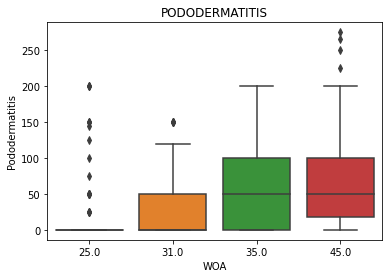

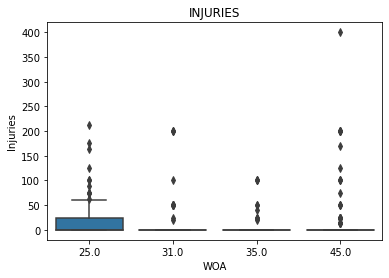

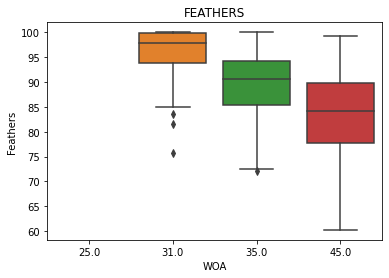

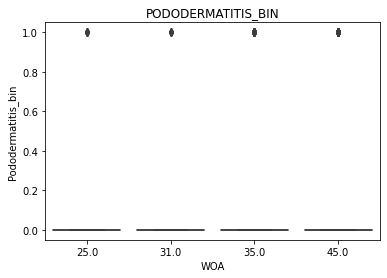

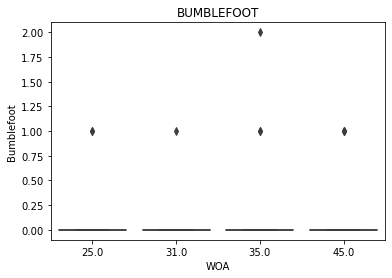

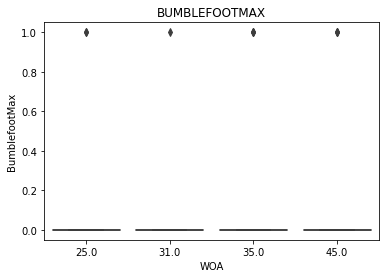

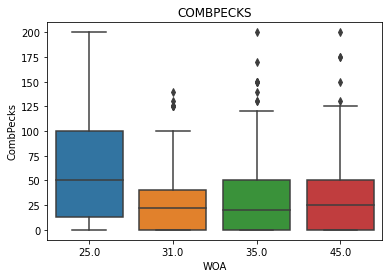

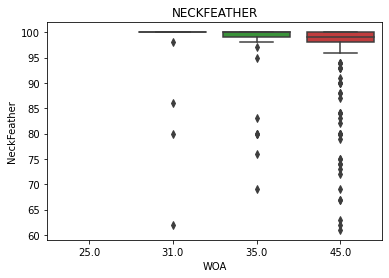

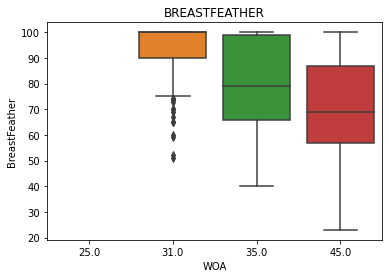

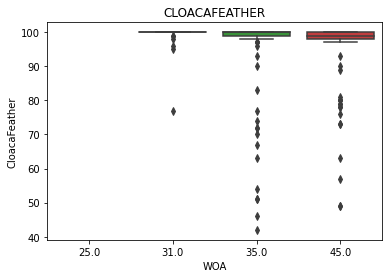

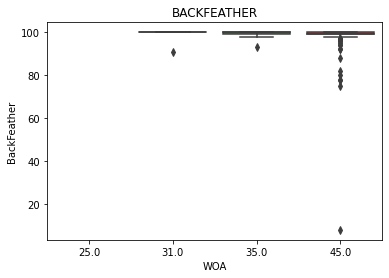

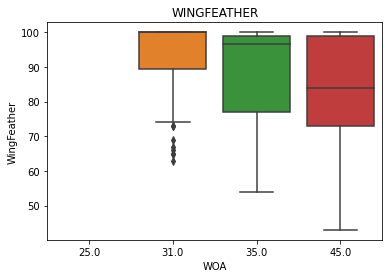

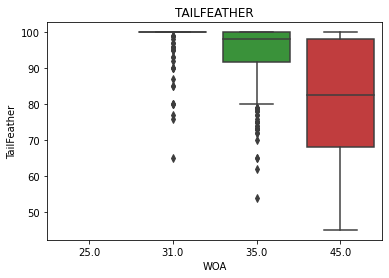

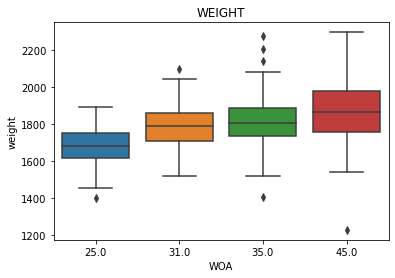

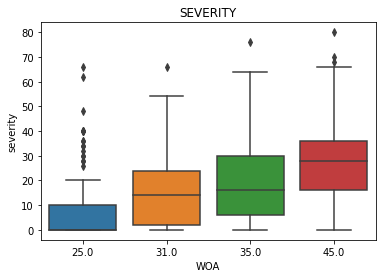

In [59]:
for v in li_HAvar:
    ax = sns.boxplot(x="WOA", y=v, data=df_HA_KBF[~df_HA_KBF['IsNonFocal']]);
    plt.title(v.upper())
    plt.savefig(os.path.join(path_extracted_HA_visual,v+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

# Non focal vs Focal

In [ ]:
'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\HA\\HA5'

In [5]:
path_extracted_data

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\TrackingSystem\\correctlightschedule_'

In [6]:
#focal birds info (one row per bird) for weight
path_nf = 'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\HA\\HA5'
df_NF = pd.read_csv(os.path.join(path_nf, 'non-focalbirds.csv'), sep=';') 
#df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
print(df_NF.shape)
df_NF.head(3)
TODO: MERGE TO THE ALL HA

(48, 3)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,FocalLegringName,weight
0,3,68orange,"1746,1"
1,3,60orange,1752
2,3,5orange,"1916,5"


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


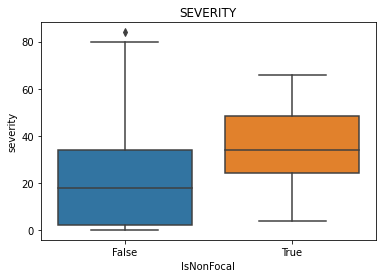

In [60]:
for v in ['severity']:
    ax = sns.boxplot(x="IsNonFocal", y=v, data=df_HA_KBF);
    plt.title(v.upper())
    plt.savefig(os.path.join(path_extracted_HA_visual,v+'NFvsF.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


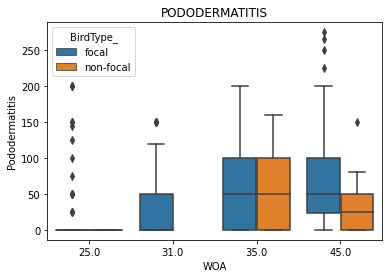

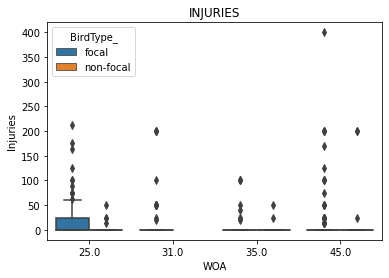

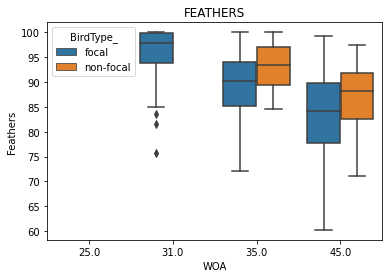

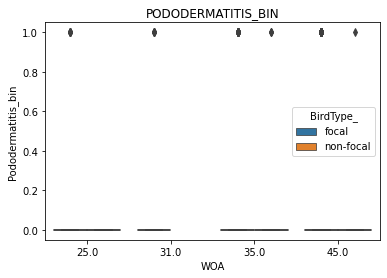

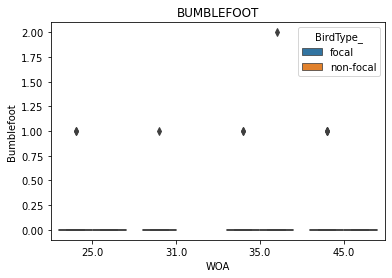

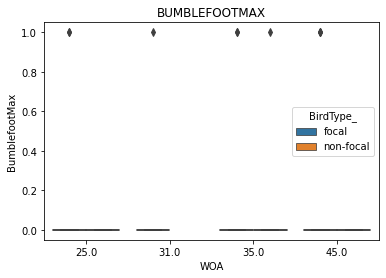

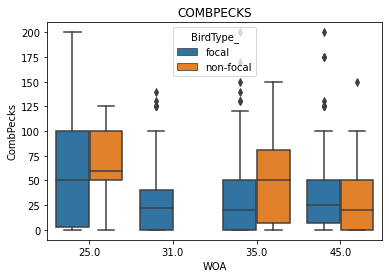

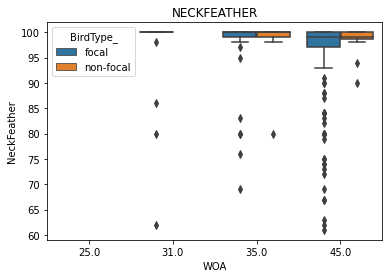

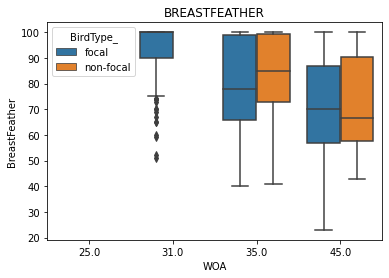

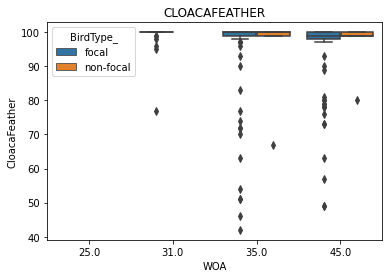

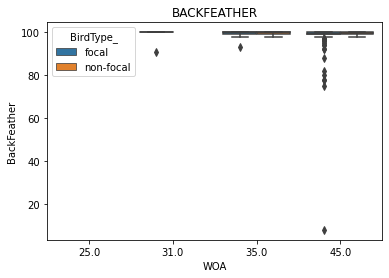

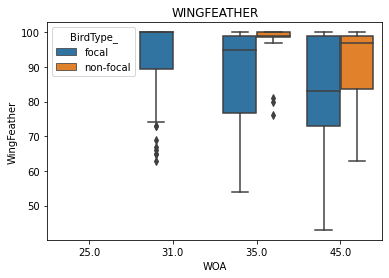

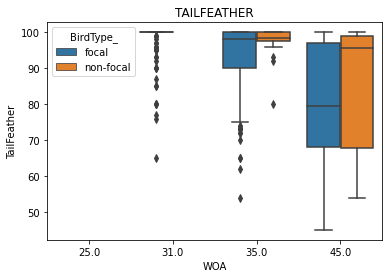

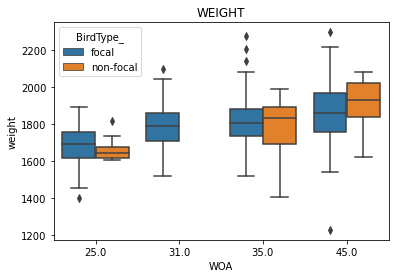

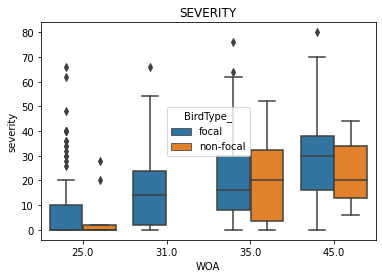

In [61]:
df_HA_KBF['BirdType_'] = df_HA_KBF['BirdType'].map(lambda x: 'non-focal' if x=='epi new' else 'focal')
for v in li_HAvar:
    ax = sns.boxplot(x="WOA", y=v, data=df_HA_KBF, hue='BirdType_');
    plt.title(v.upper())
    plt.savefig(os.path.join(path_extracted_HA_visual,v+'BirdType.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()